--- Network Architecture ---
DeepRitzNet(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): ResBlock(
      (fc1): Linear(in_features=100, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=100, bias=True)
      (activation): Tanh()
    )
    (3): ResBlock(
      (fc1): Linear(in_features=100, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=100, bias=True)
      (activation): Tanh()
    )
    (4): ResBlock(
      (fc1): Linear(in_features=100, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=100, bias=True)
      (activation): Tanh()
    )
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
)
Number of parameters (n_L): 61001
--- Starting Training (Clamped Plate) with Curriculum ---

Running Adam (with stratified resampling + curriculum)...
Epoch 1000/20000 [Adam] LR:5.0e-04 Loss:-0.131777 LambdaBC:5.0
Epoch 2000/20000 [Adam] LR:5.

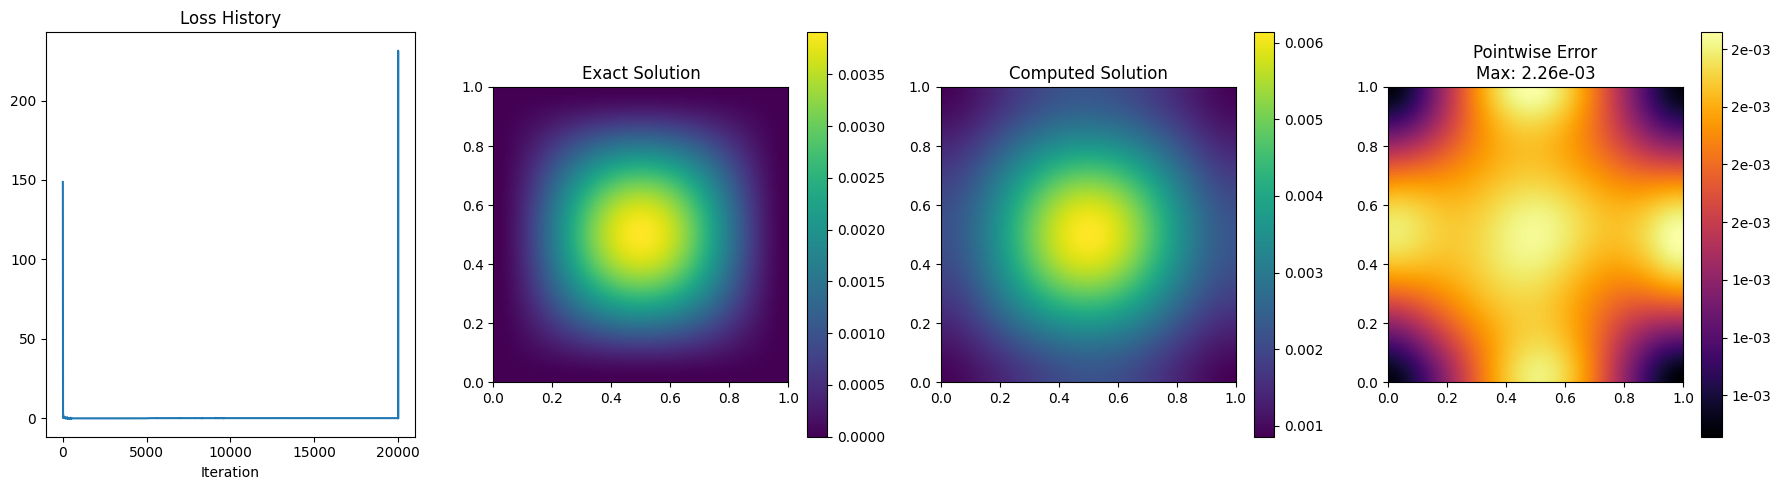

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

# ---------------------------------------------------------------------
# Configuration & Setup
# ---------------------------------------------------------------------
# 1. Use float64 everywhere
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
# Max values for curriculum learning
LAMBDA_BC_MAX = 500.0       # Strong penalty for BCs at the end
LAMBDA_MEAN_MAX = 0.0       # Not needed for Clamped Plate (Dirichlet fixes constant)
EPOCHS_ADAM = 20000         # Sufficient for convergence
EPOCHS_LBFGS = 500          # Polish
LR_ADAM = 5e-4
NUM_POINTS_DOMAIN = 10000
NUM_POINTS_BOUNDARY = 4000
SCALE = 1.0                 # No scaling needed for this polynomial magnitude

# ---------------------------------------------------------------------
# 1. Neural Network Architecture (DeepRitzNet)
# ---------------------------------------------------------------------
class ResBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.Tanh()):
        super(ResBlock, self).__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(out_features, out_features)
        self.activation = activation

    def forward(self, x):
        out = self.activation(self.fc1(x))
        out = self.fc2(out)
        return self.activation(out + x)

class DeepRitzNet(nn.Module):
    def __init__(self, num_layers=3, hidden_size=100):
        super(DeepRitzNet, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]
        for _ in range(num_layers):
            layers.append(ResBlock(hidden_size, hidden_size, activation=nn.Tanh()))
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

        # Calculate parameters
        self.n_L = sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, x):
        return self.net(x)

# 2. Xavier Initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('tanh'))
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# ---------------------------------------------------------------------
# 2. Exact Solution & Autograd-based Target Generation
# ---------------------------------------------------------------------
def exact_u_func(x):
    # u = x^2 * y^2 * (1-x)^2 * (1-y)^2
    return (x[:, 0:1]**2) * (x[:, 1:2]**2) * ((1 - x[:, 0:1])**2) * ((1 - x[:, 1:2])**2)

def get_exact_data(x, n=None):
    """
    Computes f (Delta^2 u) automatically using autograd derived from exact_u.
    """
    x_temp = x.clone().detach().requires_grad_(True)
    u = exact_u_func(x_temp)

    # First Derivatives
    grad_u = torch.autograd.grad(u, x_temp, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Laplacian (Delta u)
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x_temp, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x_temp, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy

    # Gradient of Laplacian
    grad_lap_u = torch.autograd.grad(lap_u, x_temp, grad_outputs=torch.ones_like(lap_u), create_graph=True)[0]

    # Bi-Laplacian (Delta^2 u) -> f
    lap_u_xx = torch.autograd.grad(grad_lap_u[:, 0:1], x_temp, grad_outputs=torch.ones_like(grad_lap_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    lap_u_yy = torch.autograd.grad(grad_lap_u[:, 1:2], x_temp, grad_outputs=torch.ones_like(grad_lap_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    bilap_u = lap_u_xx + lap_u_yy

    f_val = bilap_u.detach()

    # For this specific problem (Clamped Plate with u=0 on boundary),
    # we just need f. Boundary targets are implicitly 0 for this solution.
    return f_val

# ---------------------------------------------------------------------
# 3. Derivatives Helper (For Network)
# ---------------------------------------------------------------------
def compute_model_derivatives(u, x):
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grad_u[:, 0:1], x, grad_outputs=torch.ones_like(grad_u[:, 0:1]), create_graph=True)[0][:, 0:1]
    u_yy = torch.autograd.grad(grad_u[:, 1:2], x, grad_outputs=torch.ones_like(grad_u[:, 1:2]), create_graph=True)[0][:, 1:2]
    lap_u = u_xx + u_yy
    return grad_u, lap_u

# ---------------------------------------------------------------------
# 4. Loss Function for Biharmonic Clamped Plate
# ---------------------------------------------------------------------
def loss_function(model, x_domain, x_boundary, n_boundary, f_exact, lambda_bc):
    # --- Domain Term ---
    x_domain.requires_grad_(True)
    u_domain = model(x_domain) # Input is already [0,1], no scaling needed

    _, lap_u_domain = compute_model_derivatives(u_domain, x_domain)

    # Energy: 0.5*(Delta u)^2 - f*u
    energy_domain = 0.5 * (lap_u_domain ** 2) - f_exact * u_domain
    loss_domain = torch.mean(energy_domain)

    # --- Boundary Term (Clamped Plate) ---
    # Essential BCs: u = 0 AND du/dn = 0
    x_boundary.requires_grad_(True)
    u_boundary = model(x_boundary)

    grad_u_boundary, _ = compute_model_derivatives(u_boundary, x_boundary)
    du_dn = torch.sum(grad_u_boundary * n_boundary, dim=1, keepdim=True)

    # Penalties
    loss_dirichlet = torch.mean(u_boundary ** 2)
    loss_neumann = torch.mean(du_dn ** 2)

    loss_boundary = lambda_bc * (loss_dirichlet + loss_neumann)

    # Total Loss
    total_loss = loss_domain + loss_boundary
    return total_loss, torch.mean(u_domain)

# ---------------------------------------------------------------------
# 5. Data Generation (Stratified)
# ---------------------------------------------------------------------
def get_domain_points_stratified(n):
    n_side = int(np.sqrt(n))

    idx = torch.arange(n_side, dtype=torch.float64, device=DEVICE)
    grid_x, grid_y = torch.meshgrid(idx, idx, indexing='ij')

    h = 1.0 / n_side
    noise = torch.rand(n_side**2, 2, device=DEVICE, dtype=torch.float64)

    base = torch.stack([grid_x.flatten(), grid_y.flatten()], dim=1)
    points = (base + noise) * h

    return points

def get_boundary_points(n):
    n_side = n // 4
    pts = [
        (torch.stack([torch.rand(n_side), torch.zeros(n_side)], 1), [0.0, -1.0]),
        (torch.stack([torch.rand(n_side), torch.ones(n_side)], 1),  [0.0, 1.0]),
        (torch.stack([torch.zeros(n_side), torch.rand(n_side)], 1), [-1.0, 0.0]),
        (torch.stack([torch.ones(n_side), torch.rand(n_side)], 1),  [1.0, 0.0])
    ]
    x_b = torch.cat([p[0] for p in pts], dim=0).to(DEVICE)
    n_b = torch.cat([torch.tensor([p[1]]).repeat(n_side, 1) for p in pts], dim=0).to(DEVICE)
    return x_b, n_b

# ---------------------------------------------------------------------
# 6. Training & Analysis
# ---------------------------------------------------------------------
def main():
    start_time = time.time()

    model = DeepRitzNet(num_layers=3, hidden_size=100).to(DEVICE)
    model.apply(init_weights)

    print(f"--- Network Architecture ---\n{model}")
    print(f"Number of parameters (n_L): {model.n_L}")
    print(f"--- Starting Training (Clamped Plate) with Curriculum ---\n")

    optimizer_adam = optim.Adam(model.parameters(), lr=LR_ADAM)
    scheduler = optim.lr_scheduler.StepLR(optimizer_adam, step_size=5000, gamma=0.5)

    optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=1.0, max_iter=EPOCHS_LBFGS,
                                  history_size=50, tolerance_grad=1e-7,
                                  tolerance_change=1e-9, line_search_fn="strong_wolfe")

    loss_history = []

    # --- Phase 1: ADAM ---\
    print("Running Adam (with stratified resampling + curriculum)...")
    for epoch in range(1, EPOCHS_ADAM + 1):
        # Curriculum: Ramp up lambda_bc
        if epoch <= 5000:
            cur_lambda_bc = 5.0
        elif epoch <= 10000:
            alpha = (epoch - 5000) / 5000.0
            cur_lambda_bc = 5.0 + alpha * (LAMBDA_BC_MAX - 5.0)
        else:
            cur_lambda_bc = LAMBDA_BC_MAX

        x_dom = get_domain_points_stratified(NUM_POINTS_DOMAIN)
        x_bnd, n_bnd = get_boundary_points(NUM_POINTS_BOUNDARY)

        f_dom_exact = get_exact_data(x_dom)

        optimizer_adam.zero_grad()

        loss_raw, mean_u_val = loss_function(model, x_dom, x_bnd, n_bnd,
                                             f_dom_exact, cur_lambda_bc)

        loss = loss_raw * SCALE
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer_adam.step()
        scheduler.step()

        loss_val = loss.item()
        loss_history.append(loss_val)

        if epoch % 1000 == 0:
            current_lr = scheduler.get_last_lr()[0]
            print(f"Epoch {epoch}/{EPOCHS_ADAM} [Adam] LR:{current_lr:.1e} Loss:{loss_val:.6f} LambdaBC:{cur_lambda_bc:.1f}")

    # --- Phase 2: LBFGS Polish ---\
    print("\nRunning LBFGS polish...")
    x_dom = get_domain_points_stratified(NUM_POINTS_DOMAIN)
    x_bnd, n_bnd = get_boundary_points(NUM_POINTS_BOUNDARY)
    f_dom_exact = get_exact_data(x_dom)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss_raw, _ = loss_function(model, x_dom, x_bnd, n_bnd,
                                    f_dom_exact, LAMBDA_BC_MAX)
        loss = loss_raw * SCALE
        loss.backward()
        loss_history.append(loss.item())
        return loss

    optimizer_lbfgs.step(closure)

    train_time = time.time() - start_time
    print(f"Training Completed. Final Loss: {loss_history[-1]:.6e}")
    print(f"Total Time: {train_time:.2f}s")

    # --- Error Analysis ---\
    print("\n--- Computing Errors ---\n")

    n_test = 100
    x1 = torch.linspace(0, 1, n_test)
    x2 = torch.linspace(0, 1, n_test)
    X, Y = torch.meshgrid(x1, x2, indexing='ij')
    x_test = torch.stack([X.flatten(), Y.flatten()], dim=1).to(DEVICE)
    x_test.requires_grad_(True)

    u_exact = exact_u_func(x_test)
    u_pred = model(x_test)

    grad_u_pred = torch.autograd.grad(u_pred, x_test, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
    grad_u_exact = torch.autograd.grad(u_exact, x_test, grad_outputs=torch.ones_like(u_exact), create_graph=True)[0]

    def get_hessian_flat(u, x):
        grads = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ux, uy = grads[:,0:1], grads[:,1:2]
        uxx = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,0:1]
        uxy = torch.autograd.grad(ux, x, grad_outputs=torch.ones_like(ux), create_graph=True)[0][:,1:2]
        uyx = torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,0:1]
        uyy = torch.autograd.grad(uy, x, grad_outputs=torch.ones_like(uy), create_graph=True)[0][:,1:2]
        return torch.cat([uxx, uxy, uyx, uyy], dim=1)

    hess_pred = get_hessian_flat(u_pred, x_test)
    hess_exact = get_hessian_flat(u_exact, x_test)

    err_u_sq = torch.mean((u_pred - u_exact)**2).item()
    err_grad_sq = torch.mean(torch.sum((grad_u_pred - grad_u_exact)**2, dim=1)).item()
    err_hess_sq = torch.mean(torch.sum((hess_pred - hess_exact)**2, dim=1)).item()

    norm_u_sq = torch.mean(u_exact**2).item()
    norm_grad_sq = torch.mean(torch.sum(grad_u_exact**2, dim=1)).item()
    norm_hess_sq = torch.mean(torch.sum(hess_exact**2, dim=1)).item()

    l2_err = np.sqrt(err_u_sq)
    h1_err = np.sqrt(err_u_sq + err_grad_sq)
    h2_err = np.sqrt(err_u_sq + err_grad_sq + err_hess_sq)

    l2_rel = l2_err / np.sqrt(norm_u_sq)
    h1_rel = h1_err / np.sqrt(norm_u_sq + norm_grad_sq)
    h2_rel = h2_err / np.sqrt(norm_u_sq + norm_grad_sq + norm_hess_sq)

    print(f"L2 Error: {l2_err:.4e} (Rel: {l2_rel:.4e})")
    print(f"H1 Error: {h1_err:.4e} (Rel: {h1_rel:.4e})")
    print(f"H2 Error: {h2_err:.4e} (Rel: {h2_rel:.4e})")

    # --- Plotting ---\
    u_pred_np = u_pred.detach().cpu().numpy().reshape(n_test, n_test)
    u_exact_np = u_exact.detach().cpu().numpy().reshape(n_test, n_test)
    error_np = np.abs(u_pred_np - u_exact_np)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.plot(loss_history)
    plt.yscale('linear')
    plt.title("Loss History")
    plt.xlabel("Iteration")

    plt.subplot(1, 4, 2)
    plt.imshow(u_exact_np, extent=[0,1,0,1], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title("Exact Solution")

    plt.subplot(1, 4, 3)
    plt.imshow(u_pred_np, extent=[0,1,0,1], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title("Computed Solution")

    plt.subplot(1, 4, 4)
    plt.imshow(error_np, extent=[0,1,0,1], origin='lower', cmap='inferno')
    plt.colorbar(format='%.0e')
    plt.title(f"Pointwise Error\nMax: {np.max(error_np):.2e}")

    plt.tight_layout()
    plt.savefig("drm_clamped_results.png")
    plt.show()

    torch.save(model.state_dict(), "drm_clamped_model.pth")
    with open("loss_history_clamped.pkl", "wb") as f:
        pickle.dump(loss_history, f)

if __name__ == "__main__":
    main()